## Networks

In this notebook we will analyse three networks:
* __Movie's network(cast):__ This is a network where nodes will be movies and there will be a link between nodes if 10% of the cast is the same between the two nodes(movies).
* __Movie's network(keywords):__ This is a network where nodes will be movies and there will be a link between nodes if the movies share 30% of their keywords. Keywords are used to describe the movie in simple words such as for Avatar the keywords are: culture clash, future, space war, society, futuristic, romance, space, etc.
* __Cast's network:__ This is a network where nodes will be cast members from our movies and there will be a link between nodes if the cast members have starred in three or more movies together.

For all networks we will look at the following:
* What's the maximum and minimum degree?
* How is the degree distribution?
* Visualize the networks.
* Analyze Python-Louvain communities and modularity.
* Look at betweenness centrality.
* Look at clustering coefficients.

First let's get the data we need and import all packages we will be using.

In [2]:
%matplotlib inline
from __future__ import division
from collections import Counter, defaultdict
from math import log10, floor
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from scipy import spatial
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import urllib2
import json
import re
import csv
import calendar
import io
import sys
import operator
import timeit
import os
import random
import community

# Function used to round numbers to n significant numbers
def round_sig(x, sig=2):
    return round(x, sig-int(floor(log10(abs(x))))-1)

### Data

In [3]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary
filepath = r"tmdb_5000_credits.csv"
tmdb_5000_credits = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_credits[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_credits[row["title"]]['cast'] = json.loads(tmdb_5000_credits[row["title"]]['cast'])
        tmdb_5000_credits[row["title"]]['crew'] = json.loads(tmdb_5000_credits[row["title"]]['crew'])

In [4]:
# Get data line by line from tmdb-5000-movie-database and save the data as dictionary
filepath = r"tmdb_5000_movies.csv"
tmdb_5000_movies = defaultdict(dict)

with open(filepath) as csvfile:
    reader = csv.DictReader(csvfile, delimiter=",")
    for row in reader:
        tmdb_5000_movies[row["title"]] = row
        # put the lists and dictonaries to a correct format, (that is not as string)
        tmdb_5000_movies[row["title"]]['genres'] = json.loads(tmdb_5000_movies[row["title"]]['genres'])
        tmdb_5000_movies[row["title"]]['keywords'] = json.loads(tmdb_5000_movies[row["title"]]['keywords'])
        tmdb_5000_movies[row["title"]]['production_companies'] = json.loads(tmdb_5000_movies[row["title"]]['production_companies'])

## Movie's network (cast)

In [13]:
# lets build the first network
G_movies_cast = nx.Graph()

# get all the movies
movies = list(tmdb_5000_movies.keys())

# ratio of number of common actors that movies have to pass to be consider similar
connecting_actor_ratio = 0.1

# loop thorugh all the pairs and check if we have enough evidance to insert a link
for i in xrange(len(movies)-1):
    
    # extract all the actors from the first movie
    actors_i = [cast_i['id'] for cast_i in tmdb_5000_credits[movies[i]]['cast']]
    
    for j in xrange(i + 1, len(movies)):
        
        # extract all the actors from the second movie
        actors_j = [cast_j['id'] for cast_j in  tmdb_5000_credits[movies[j]]['cast']]
        
        # ensure we dont divide by zero
        if min(len(actors_i), len(actors_j)) != 0:
                
            # claculate the actor ratio of the two movies, using the smaller keywords list
            actor_ratio = len(set(actors_i).intersection(set(actors_j))) / min(len(actors_i), len(actors_j))
            
            # if number of common actors is more than the 'num_common_keywords' we insert a edge, between the nodes
            if actor_ratio > connecting_actor_ratio:
                G_movies_cast.add_edge(movies[i], movies[j])


### Maximum and minimum degree

In [14]:
# Find the maximum and minimum degree of the network
print "The minimum degree of the network is: {}".format(min(G_movies_cast.degree().values()))
print "The maximum degree of the network is: {}".format(max(G_movies_cast.degree().values()))

The minimum degree of the network is: 1
The maximum degree of the network is: 190


Let's see what movie has the highest degrees.

In [15]:
max(G_movies_cast.degree().iteritems(), key=operator.itemgetter(1))[0]

'Final Fantasy: The Spirits Within'

The movie with the highest degree is 'Final Fantasy: The Spirits Within'. Let's look a bit into why this average movie (6.4/10 IMDb rating, with 75,697 votes) is a hub.

In [16]:
#Let's look a the cast of the movie
cast_final_fantasty = [str(x['name']) for x in tmdb_5000_credits['Final Fantasy: The Spirits Within']['cast']]
print "The cast of Final Fantasy: The Spirits Within"
print "---------------------------------------------"
for cast_member in cast_final_fantasty:
    print cast_member

The cast of Final Fantasy: The Spirits Within
---------------------------------------------
Donald Sutherland
Ming-Na Wen
Alec Baldwin
Ving Rhames
Steve Buscemi
Peri Gilpin
James Woods
Jean Simmons
Keith David


This movie only has 9 cast members in our data, therefore it is enough to only have one cast member in common with a movie to get a link to said movie as 10% of 9 is 0.9. The cast includes multiple Hollywood heavy-hitters and the average number of acting credits for this cast on IMDb is ~140. Therefore it is understandable that this movie is the biggest hub in this network.

### Degree distribution

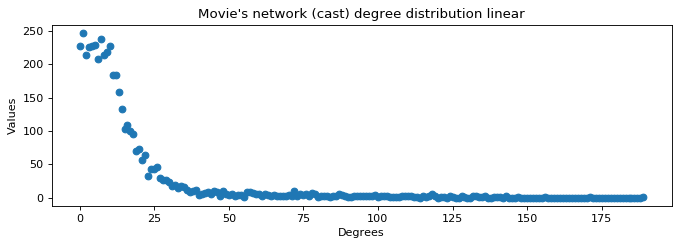

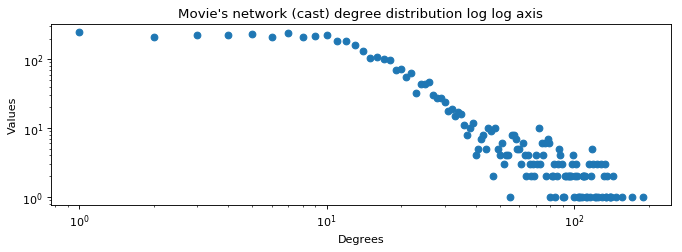

In [17]:
# Plot the distribution, both linear and log-log axes

# bin the degree distribution using np.histogram
values, bins = np.histogram(G_movies_cast.degree().values(), bins=max(G_movies_cast.degree().values()))

# linear plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.title("Movie's network (cast) degree distribution linear")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

# log log plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Movie's network (cast) degree distribution log log axis")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

As we can see the degree distribution follows a power law distribution, this tells us that this is a scale-free network.

### Visualization of the network

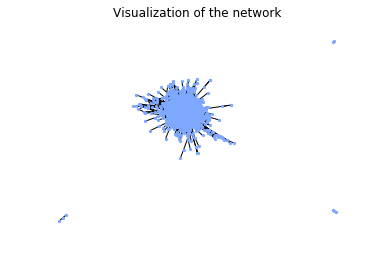

In [24]:
# plot the network
plt.title('Visualization of the network')
nx.draw_spring(G_movies_cast,node_size = 5, node_color = "#7FA8FF", with_labels = False, edge_color = "black" )
plt.show()

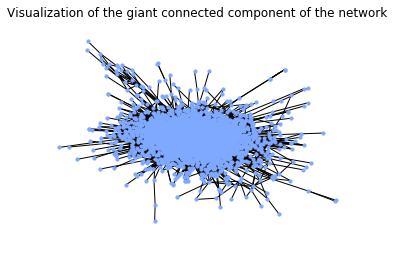

In [19]:
#Let's look at the giant connected component of the network
giant_movies_cast = max(nx.connected_component_subgraphs(G_movies_cast), key=len)

# plot the network's giant connected component
plt.title('Visualization of the giant connected component of the network')
nx.draw_spring(giant_movies_cast,node_size = 10, node_color = "#7FA8FF", with_labels = False)
plt.show()

### Analyze Python-Louvain communities and modularity

In [20]:
# First compute the best partition
partition_movies_cast = community.best_partition(giant_movies_cast)

# Find how many communities there are in the partition 
communities_movies_cast = Counter([value for key,value in partition_movies_cast.items()])

print "The giant component of the actors network is split up to {} communities".format(len(communities_movies_cast))
print "The modularity of this community division is {}".format(
    community.modularity(partition_movies_cast,giant_movies_cast)
)

The giant component of the actors network is split up to 20 communities
The modularity of this community division is 0.343864690746


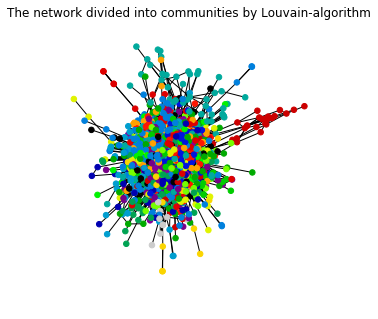

In [21]:
# The network divided into communities by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_movies_cast.get(node) for node in giant_movies_cast.nodes()]
plt.title('The network divided into communities by Louvain-algorithm')
nx.draw_spring(giant_movies_cast, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.show()

Let's look at the genres of the community to see if there is any pattern or anomalies.

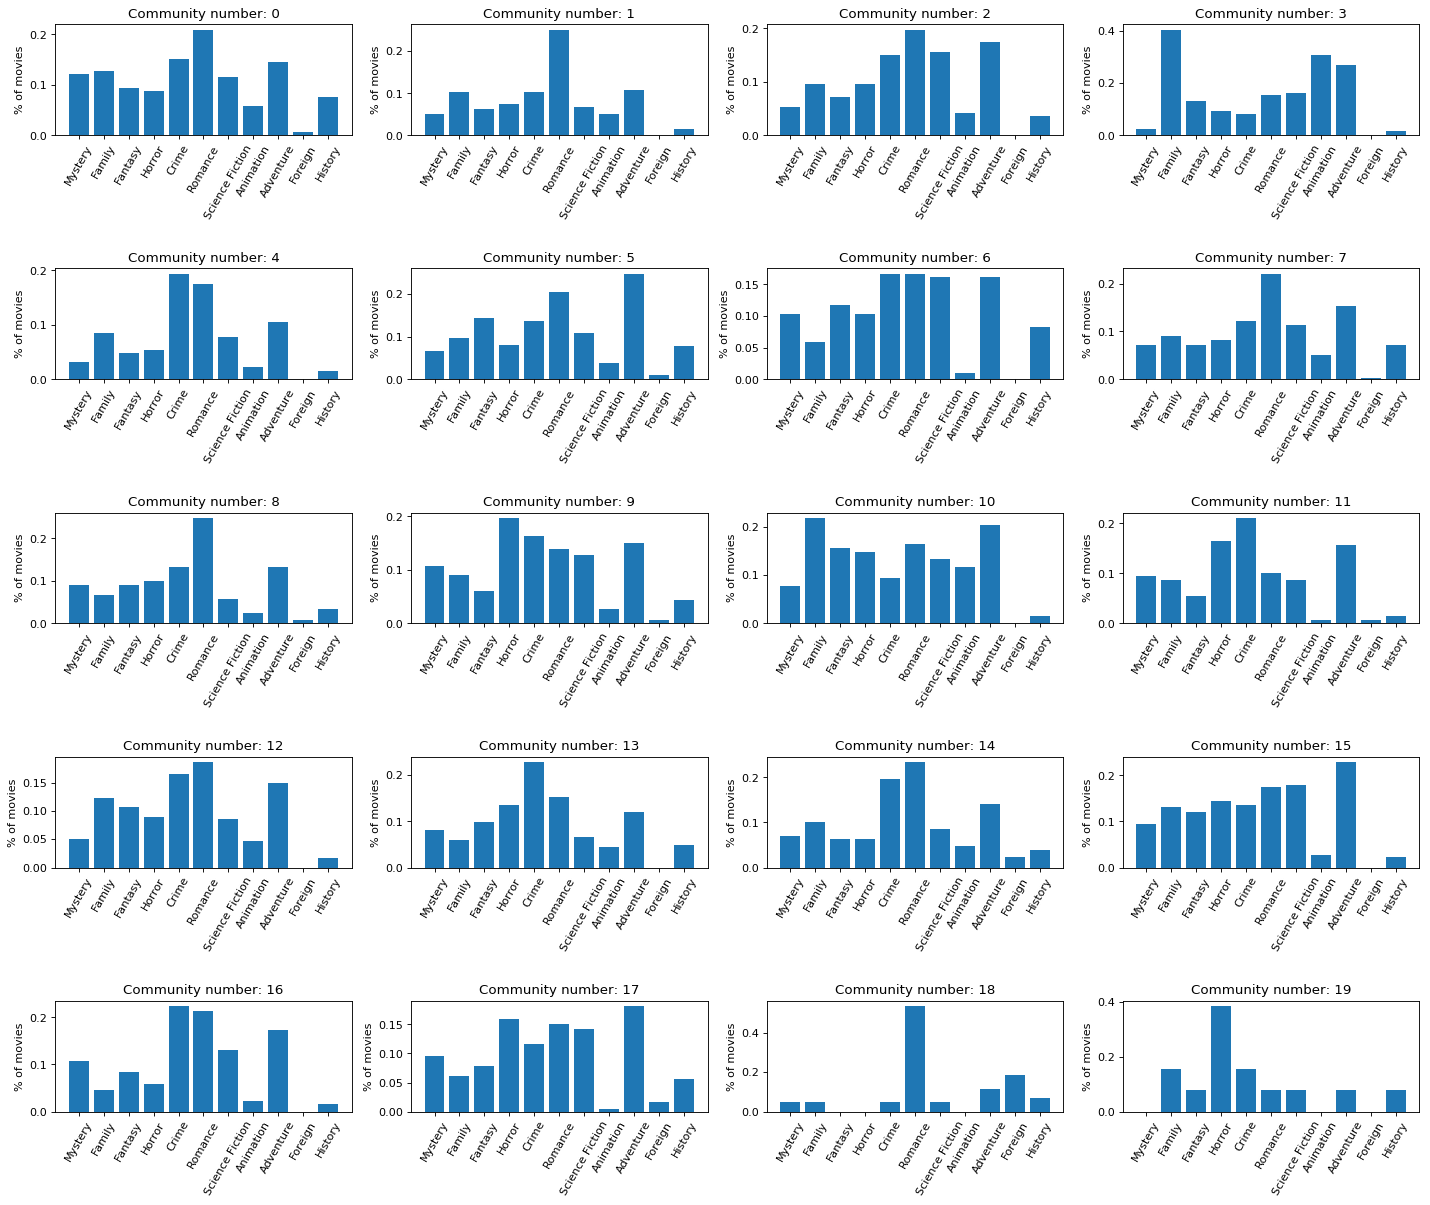

In [191]:
genre_dict = {}
#As most movies have some of the following genres we will not be looking at them
not_interested = [u'Thriller', u'Comedy', u'Drama', u'Action']

#Loop through the partitions
for i in partition_movies_cast:
    #We will create a dictionary for each partition
    if partition_movies_cast[i] not in genre_dict:
        genre_dict[partition_movies_cast[i]] = {}
    for genre in tmdb_5000_movies[i]['genres']:
        #We count the number of genre occurences of the ones we are interested in
        if genre['name'] not in not_interested:
            if genre['name'] in genre_dict[partition_movies_cast[i]]:
                genre_dict[partition_movies_cast[i]][genre['name']] += 1
            else:
                genre_dict[partition_movies_cast[i]][genre['name']] = 1

#We don't want to look at all genres, let's just take the union of the 5 most common genres
names = []
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    names += [str(x[0]) for x in genre_counter.most_common(5)]

#Plot our findings
names = set(names)
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    values = [genre_counter[x]/communities_movies_cast[genre] for x in names]
    plt.figure(num=20, figsize=(22, 18), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(5,4,genre+1)
    plt.bar(range(0,len(names)), values)
    plt.xticks(range(0,len(names)), names, rotation=60)
    plt.title('Community number: ' + str(genre))
    plt.ylabel('% of movies')

plt.subplots_adjust(hspace=1.2)
plt.show()

Here we can see that some communities correlate in some way to a genre, e.g community number 18 with around 60% of its movies labeled as 'Romance' movies, community 19 with 40% of its movies labeled as 'Horror' and community 3 that we can assume are kids movies in a sense as 'Family', 'Animation' and 'Adventure' are popular genres in that community. There is little to say about the rest as multiple genres share the tally of the movies in the communities. We can therefore see that this network would probably not be sufficient as a basis for our recommendation engine.

### Betweenness centrality

In [193]:
#Calculate the betweenness of the network
betweenness = nx.betweenness_centrality(G_movies_cast)

In [303]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{movie_s: <46} {centrality_d: <14}".format(
            movie_s = "Movie:", centrality_d = "Betweenness centrality value:"
        ))

print("------------------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{movie_s: <46} {centrality_d: <14}".format(
            movie_s = page, centrality_d = round_sig(centrality,5)
        ))

Movie:                               Betweenness centrality value:
------------------------------------------------------------------
Peeples                              0.053533      
Bran Nue Dae                         0.027169      
The Joneses                          0.026579      
Cats & Dogs 2 : The Revenge of Kitty Galore 0.026144      
Ant-Man                              0.021044      


In [220]:
#Let's look a the cast of the movies
for page, centrality in betweenness_sorted[:5]:
    cast_movie = [str(x['name']) for x in tmdb_5000_credits[page]['cast']]
    print "The cast of " + page
    print "-"*(len(page)+12)
    for cast_member in cast_movie:
        print cast_member
    print

The cast of Final Fantasy: The Spirits Within
---------------------------------------------
Donald Sutherland
Ming-Na Wen
Alec Baldwin
Ving Rhames
Steve Buscemi
Peri Gilpin
James Woods
Jean Simmons
Keith David

The cast of Titan A.E.
----------------------
Matt Damon
Bill Pullman
Drew Barrymore
John Leguizamo
Nathan Lane
Janeane Garofalo
Ron Perlman
Alex D. Linz

The cast of For Love of the Game
--------------------------------
Kevin Costner
Kelly Preston
John C. Reilly
Jena Malone
J.K. Simmons
Brian Cox
David Mucci

The cast of Cats & Dogs
-----------------------
Jeff Goldblum
Elizabeth Perkins
Alexander Pollock
Miriam Margolyes
Tobey Maguire
Alec Baldwin
Susan Sarandon
Charlton Heston

The cast of Beyond the Sea
--------------------------
Kevin Spacey
Kate Bosworth
John Goodman
Bob Hoskins
Brenda Blethyn
Greta Scacchi
Michael Byrne
Caroline Aaron



Here the same reasons apply as when finding the movie with highest degree. All these movies have less than 10 cast members which mean that to link another movie they only need to have one cast member in common. For all movies there are also very big actors/actresses in the cast, e.g. Steve Buscemi, Matt Damon, Kevin Costner, Susan Sarandon, John Goodman. 

### Clustering coefficients

In [218]:
print "The clustering coefficent for the network is: {}".format(nx.average_clustering(G_movies_cast))

The clustering coefficent for the network is: 0.187888917353


In [219]:
print "The clustering coefficent for the GCC of the network is: {}".format(nx.average_clustering(giant_movies_cast))

The clustering coefficent for GCC of the network is: 0.188222645448


### __***Túlka***__

### Conclusion
We see that this network is not sufficient for our recommendation engine, at least not on its own. The clustering coefficient is not high and the modularity of our 20 communities is okay but this network doesn't include all our movies. We'll therefore move onto the next one and see if that has some interesting things to offer.

## Movie's network(keywords)

In [250]:
# lets build the second network
G_movies_keywords = nx.Graph()

# all movies
movies = tmdb_5000_movies.keys()

# ratio of similar keywords that movies have to pass to be consider similar
min_keyword_ratio = 0.5


# loop thorugh all the pairs and check if we have enough evidance to insert a link
for i in xrange(len(movies)):
    
    # extract all the keywords from the first movie
    keywords_i = [keyword_i['name'] for keyword_i in tmdb_5000_movies[movies[i]]['keywords']]
    
    for j in xrange(i + 1, len(movies)):

        # all the keywords from the second movie
        keywords_j = [keyword_j['name'] for keyword_j in tmdb_5000_movies[movies[j]]['keywords']]
        
        # ensure that we dont divide by zero
        if min(len(keywords_i), len(keywords_j)) != 0:
            
            # claculate the keyword ratio of the two movies, using the smaller keywords list
            keyword_ratio = len(set(keywords_i).intersection(set(keywords_j))) / np.mean([len(keywords_i), len(keywords_j)])
            
            # if number of comon actors is more than the 'num_common_keywords' we insert a edge, between the nodes
            if keyword_ratio > min_keyword_ratio:
                G_movies_keywords.add_edge(movies[i], movies[j])


### Maximum and minimum degree

In [251]:
# Find the maximum and minimum degree of the network
print "The minimum degree of the network is: {}".format(min(G_movies_keywords.degree().values()))
print "The maximum degree of the network is: {}".format(max(G_movies_keywords.degree().values()))

The minimum degree of the network is: 1
The maximum degree of the network is: 117


Let's see what movie has the highest degrees.

In [252]:
max(G_movies_keywords.degree().iteritems(), key=operator.itemgetter(1))[0]

'Obvious Child'

In [321]:
#Let's look at the keywords of the movie
keywords_obvious_child = [str(x['name']) for x in tmdb_5000_movies[max(G_movies_keywords.degree().iteritems(), key=operator.itemgetter(1))[0]]['keywords']]
print "The keywords of " + max(G_movies_keywords.degree().iteritems(), key=operator.itemgetter(1))[0] + ":"
print "------------------------------"
for keyword in keywords_obvious_child:
    print keyword

The keywords of Obvious Child:
------------------------------
independent film
woman director


The movie with the highest degree is 'Obvious Child'. The reason for this is that it only has two keywords so just one has to match another movie to create a link between those movies. 'woman director' is a rather popular keyword.

### Degree distribution

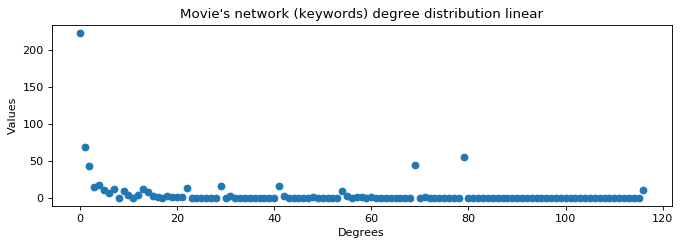

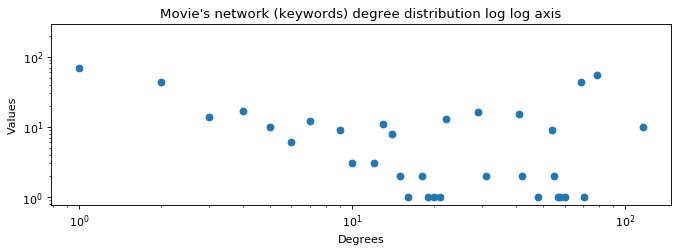

In [258]:
# Plot the distribution, both linear and log-log axes

# bin the degree distribution using np.histogram
values, bins = np.histogram(G_movies_keywords.degree().values(), bins=max(G_movies_keywords.degree().values()))

# linear plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.title("Movie's network (keywords) degree distribution linear")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

# log log plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Movie's network (keywords) degree distribution log log axis")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

### __Túlka__

### Visualization of the network

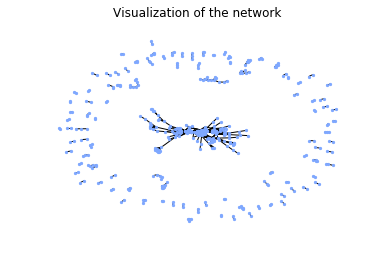

In [339]:
# plot the network
plt.title('Visualization of the network')
nx.draw_spring(G_movies_keywords,node_size = 5, node_color = "#7FA8FF", with_labels = False, edge_color = "black" )
plt.show()

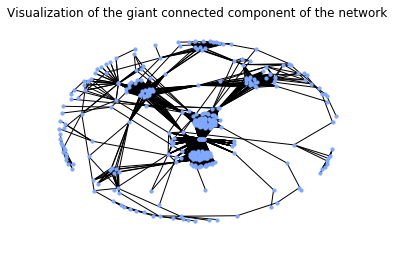

In [338]:
#Let's look at the giant connected component of the network
giant_movies_keywords = max(nx.connected_component_subgraphs(G_movies_keywords), key=len)

# plot the network's giant connected component
plt.title('Visualization of the giant connected component of the network')
nx.draw_spring(giant_movies_keywords,node_size = 10, node_color = "#7FA8FF", with_labels = False)
plt.show()

### Analyze Python-Louvain communities and modularity

In [346]:
# First compute the best partition
partition_movies_keywords = community.best_partition(giant_movies_keywords)

# Find how many communities there are in the partition 
communities_movies_keywords = Counter([value for key,value in partition_movies_keywords.items()])

print "The giant component of the keywords network is split up to {} communities".format(len(communities_movies_keywords))
print "The modularity of this community division is {}".format(
    community.modularity(partition_movies_keywords,giant_movies_keywords)
)

The giant component of the keywords network is split up to 11 communities
The modularity of this community division is 0.511793945441


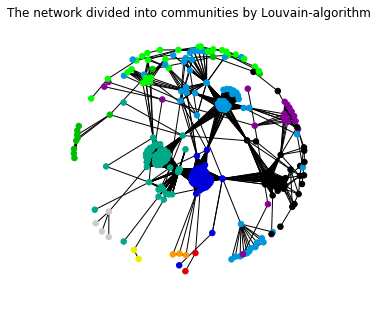

In [287]:
# The network divided into communities by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_movies_keywords.get(node) for node in giant_movies_keywords.nodes()]
plt.title('The network divided into communities by Louvain-algorithm')
nx.draw_spring(giant_movies_keywords, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.show()

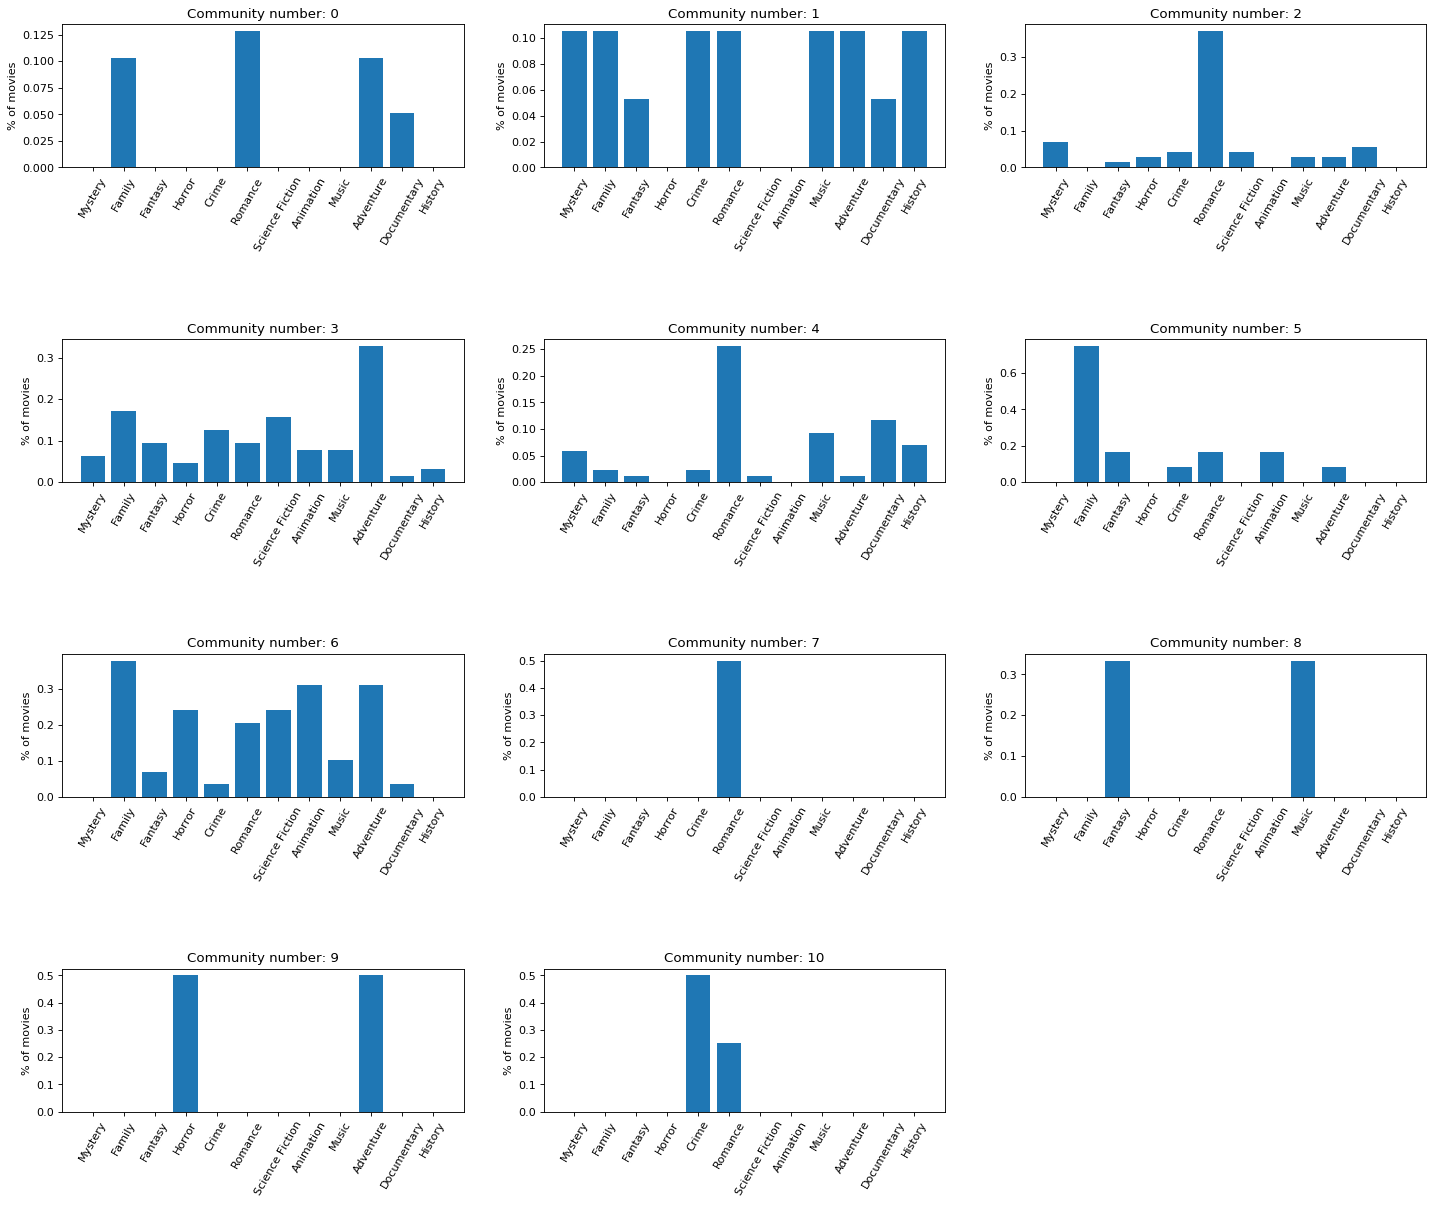

In [291]:
genre_dict = {}
#As most movies have some of the following genres we will not be looking at them
not_interested = [u'Thriller', u'Comedy', u'Drama', u'Action']

#Loop through the partitions
for i in partition_movies_keywords:
    #We will create a dictionary for each partition
    if partition_movies_keywords[i] not in genre_dict:
        genre_dict[partition_movies_keywords[i]] = {}
    for genre in tmdb_5000_movies[i]['genres']:
        #We count the number of genre occurences of the ones we are interested in
        if genre['name'] not in not_interested:
            if genre['name'] in genre_dict[partition_movies_keywords[i]]:
                genre_dict[partition_movies_keywords[i]][genre['name']] += 1
            else:
                genre_dict[partition_movies_keywords[i]][genre['name']] = 1

#We don't want to look at all genres, let's just take the union of the 5 most common genres
names = []
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    names += [str(x[0]) for x in genre_counter.most_common(5)]

#Plot our findings
names = set(names)
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    values = [genre_counter[x]/communities_movies_keywords[genre] for x in names]
    plt.figure(num=20, figsize=(22, 18), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(4,3,genre+1)
    plt.bar(range(0,len(names)), values)
    plt.xticks(range(0,len(names)), names, rotation=60)
    plt.title('Community number: ' + str(genre))
    plt.ylabel('% of movies')

plt.subplots_adjust(hspace=1.2)
plt.show()

These communities look a bit better than the communities of the movie network derived from the cast, that is when compared to genres. Here we have a relation between communities and genres. Communities 0,2,4 and 7 contain a lot of romantic movies although with different subgenres. Community 1 is rather divided and seems to contain some foreign films, which can explain the division as foreign films can be of all genres. Community 3 contains Adventur movies, a lot superhero movies for example. Community 5 only contains christmas movies and is extremely high in the Family genre. Community 6 contains mostly animated films, of which many are considered to Family movies. Community 8 is high in Music and Fantasty. Community 9 is high in Horror and Adventure, although it only contains two movies so there isn't much to say about that. Community 10 is high in Crime and Romance. It should be noted that communities 7-10 only contained 2-4 films each.

### Betweenness centrality

In [304]:
#Calculate the betweenness of the network
betweenness = nx.betweenness_centrality(G_movies_keywords)

In [309]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{movie_s: <44} {centrality_d: <14}".format(
            movie_s = "Movie:", centrality_d = "Betweenness centrality value:"
        ))

print("--------------------------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{movie_s: <44} {centrality_d: <14}".format(
            movie_s = page, centrality_d = round_sig(centrality,5)
        ))

Movie:                                       Betweenness centrality value:
--------------------------------------------------------------------------
Peeples                                      0.053533      
Bran Nue Dae                                 0.027169      
The Joneses                                  0.026579      
Cats & Dogs 2 : The Revenge of Kitty Galore  0.026144      
Ant-Man                                      0.021044      


In [310]:
#Let's look a the keywords of the movies
for page, centrality in betweenness_sorted[:5]:
    cast_movie = [str(x['name']) for x in tmdb_5000_movies[page]['keywords']]
    print "The keywords of " + page
    print "-"*(len(page)+12)
    for cast_member in cast_movie:
        print cast_member
    print

The keywords of Peeples
-------------------
duringcreditsstinger
woman director

The keywords of Bran Nue Dae
------------------------
musical
woman director

The keywords of The Joneses
-----------------------
independent film
duringcreditsstinger

The keywords of Cats & Dogs 2 : The Revenge of Kitty Galore
-------------------------------------------------------
torture
aftercreditsstinger
duringcreditsstinger
3d

The keywords of Ant-Man
-------------------
marvel comic
superhero
based on comic book
aftercreditsstinger
duringcreditsstinger
marvel cinematic universe
3d



Here we can see that movies with few keywords are more likely to be hubs as we use ratio to decide whether to movies should be linked. This is not ideal and perhaps we should've used a fixed number but then we would've had to discard some movies. We can also see that 'aftercreditsstinger', 'duringcreditsstinger', 'woman director' and 'foreign film' are obviously popular keywords.

### Clustering coefficients

In [312]:
print "The clustering coefficent for the network is: {}".format(nx.average_clustering(G_movies_keywords))

The clustering coefficent for the network is: 0.468008450066


In [313]:
print "The clustering coefficent for the GCC of the network is: {}".format(nx.average_clustering(giant_movies_keywords))

The clustering coefficent for the network is: 0.693355053688


### __***Túlka***__

### Conclusion
We see that this network is not sufficient for our recommendation engine, at least not on its own. While the clustering coefficient is high and the modularity of our 11 communities as well, the network again doesn't include all our movies. We'll therefore move onto the next one and see if that has some interesting things to offer.

## Cast's network

In [5]:
#Lets get all actors/actresses first, we'll create a dictinoary with key as cast id and value as list of movie titles
cast = defaultdict(dict)

for i in tmdb_5000_credits:
    for j in tmdb_5000_credits[i]['cast']:
        if j['id'] in cast:
            cast[j['id']]['movies'].append(i)
        else:
            cast[j['id']]['movies'] = [i]
            cast[j['id']]['name'] = j['name']

In [6]:
#Lets build the network
G_cast = nx.Graph()

# get all the movies
actors = list(cast.keys())

# ratio of number of common actors that movies have to pass to be consider similar
connecting_actor_ratio = 3



# loop thorugh all the pairs and check if we have enough evidance to insert a link
for i in xrange(len(actors)-1):
    
    # extract all the actors from the first movie
    actors_i = cast[actors[i]]['movies']
    
    for j in xrange(i + 1, len(actors)):
        
        # extract all the actors from the second movie
        actors_j = cast[actors[j]]['movies']

        # ensure we dont divide by zero
        if min(len(actors_i), len(actors_j)) != 0:
                
            # calculate the actor ratio of the two movies, using the smaller keywords list
            actor_ratio = len(set(actors_i).intersection(set(actors_j)))
            
            # if number of comon actors is more than the 'num_common_keywords' we insert a edge, between the nodes
            if actor_ratio > connecting_actor_ratio:
                G_cast.add_edge(actors[i], actors[j])


### Maximum and minimum degree

In [7]:
# Find the maximum and minimum degree of the network
print "The minimum degree of the network is: {}".format(min(G_cast.degree().values()))
print "The maximum degree of the network is: {}".format(max(G_cast.degree().values()))

The minimum degree of the network is: 1
The maximum degree of the network is: 30


In [8]:
max(G_cast.degree().iteritems(), key=operator.itemgetter(1))[0]

4566

In [9]:
#Let's look at the movies of the actor
keywords_obvious_child = [x for x in cast[max(G_cast.degree().iteritems(), key=operator.itemgetter(1))[0]]['movies']]
print "The movies of " + cast[max(G_cast.degree().iteritems(), key=operator.itemgetter(1))[0]]['name'] + ":"
print "---------------------------"
for keyword in keywords_obvious_child:
    print keyword

The movies of Alan Rickman:
---------------------------
Quigley Down Under
Galaxy Quest
Harry Potter and the Prisoner of Azkaban
Alice Through the Looking Glass
Alice in Wonderland
The Butler
Bottle Shock
Harry Potter and the Goblet of Fire
Harry Potter and the Philosopher's Stone
Robin Hood: Prince of Thieves
Perfume: The Story of a Murderer
Harry Potter and the Chamber of Secrets
Harry Potter and the Order of the Phoenix
Sense and Sensibility
Michael Collins
Love Actually
Dogma
The Hitchhiker's Guide to the Galaxy
Die Hard
Harry Potter and the Half-Blood Prince


### Degree distribution

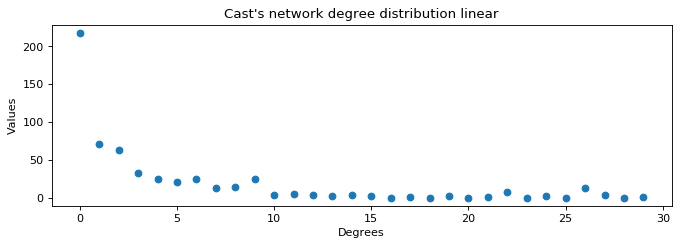

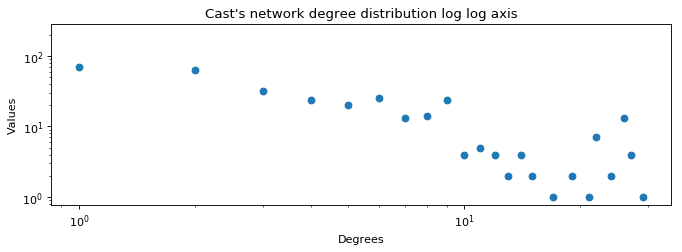

In [10]:
# Plot the distribution, both linear and log-log axes

# bin the degree distribution using np.histogram
values, bins = np.histogram(G_cast.degree().values(), bins=max(G_cast.degree().values()))

# linear plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.title("Cast's network degree distribution linear")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

# log log plot
plt.figure(num=None, figsize=(10,3), dpi=80, facecolor="w", edgecolor="k")
plt.plot(range(0,len(values)), values,'o')
plt.xscale('log')
plt.yscale('log')
plt.title("Cast's network degree distribution log log axis")
plt.xlabel("Degrees")
plt.ylabel("Values")
plt.show()

## __Túlka__

### Visualization of the network


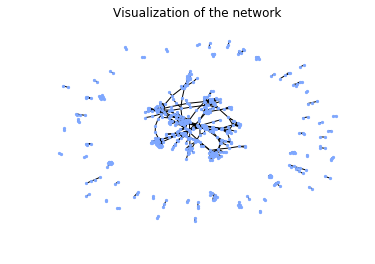

In [23]:
# plot the network
plt.title('Visualization of the network')
nx.draw_spring(G_cast,node_size = 5, node_color = "#7FA8FF", with_labels = False, edge_color = "black" )
plt.show()

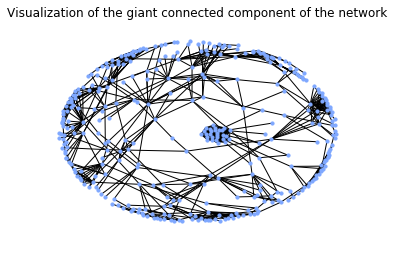

In [12]:
#Let's look at the giant connected component of the network
giant_cast = max(nx.connected_component_subgraphs(G_cast), key=len)

# plot the network's giant connected component
plt.title('Visualization of the giant connected component of the network')
nx.draw_spring(giant_cast,node_size = 10, node_color = "#7FA8FF", with_labels = False)
plt.show()

### Analyze Python-Louvain communities and modularity

In [13]:
# First compute the best partition
partition_cast = community.best_partition(giant_cast)

# Find how many communities there are in the partition 
communities_cast = Counter([value for key,value in partition_cast.items()])

print "The giant component of the cast network is split up to {} communities".format(len(communities_cast))
print "The modularity of this community division is {}".format(
    community.modularity(partition_cast,giant_cast)
)

The giant component of the cast network is split up to 14 communities
The modularity of this community division is 0.815288923182


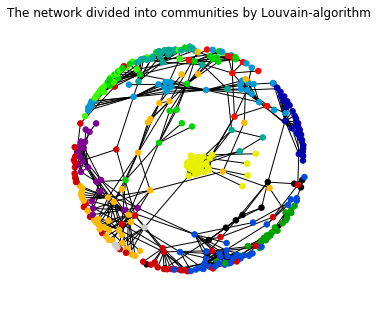

In [14]:
# The network divided into communities by the Louvain-algorithm
plt.figure(figsize=(5,5))
values = [partition_cast.get(node) for node in giant_cast.nodes()]
plt.title('The network divided into communities by Louvain-algorithm')
nx.draw_spring(giant_cast, cmap = plt.get_cmap('nipy_spectral'), node_color = values, node_size=30, with_labels=False)
plt.show()

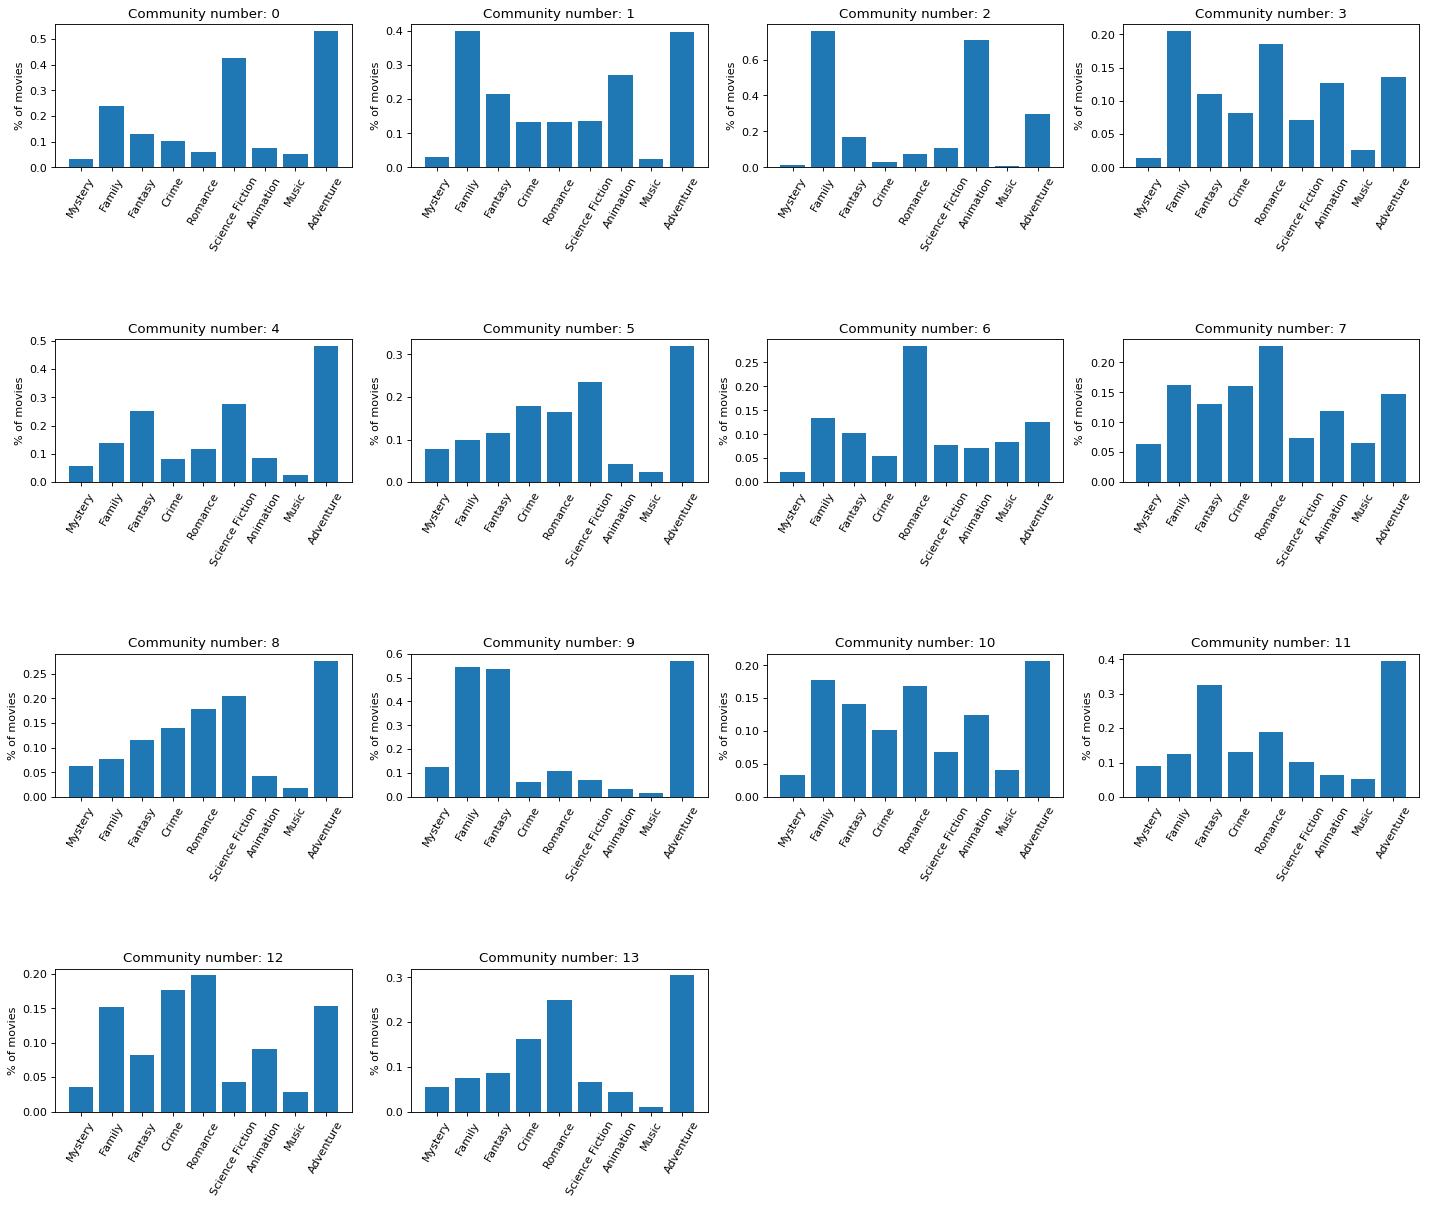

In [28]:
genre_dict = {}
movie_count = {}
#As most movies have some of the following genres we will not be looking at them
not_interested = [u'Thriller', u'Comedy', u'Drama', u'Action']

#Loop through the partitions
for i in partition_cast:
    #We will create a dictionary for each partition
    if partition_cast[i] not in genre_dict:
        genre_dict[partition_cast[i]] = {}
    if partition_cast[i] not in movie_count:
        movie_count[partition_cast[i]] = 0
    for movie in cast[i]['movies']:
        movie_count[partition_cast[i]] += 1
        for genre in tmdb_5000_movies[movie]['genres']:
            #We count the number of genre occurences of the ones we are interested in
            if genre['name'] not in not_interested:
                if genre['name'] in genre_dict[partition_cast[i]]:
                    genre_dict[partition_cast[i]][genre['name']] += 1
                else:
                    genre_dict[partition_cast[i]][genre['name']] = 1

#We don't want to look at all genres, let's just take the union of the 5 most common genres
names = []
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    names += [str(x[0]) for x in genre_counter.most_common(5)]

#Plot our findings
names = set(names)
for genre in genre_dict:
    genre_counter = Counter(genre_dict[genre])
    values = [genre_counter[x]/movie_count[genre] for x in names]
    plt.figure(num=20, figsize=(22, 18), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(4,4,genre+1)
    plt.bar(range(0,len(names)), values)
    plt.xticks(range(0,len(names)), names, rotation=60)
    plt.title('Community number: ' + str(genre))
    plt.ylabel('% of movies')

plt.subplots_adjust(hspace=1.2)
plt.show()

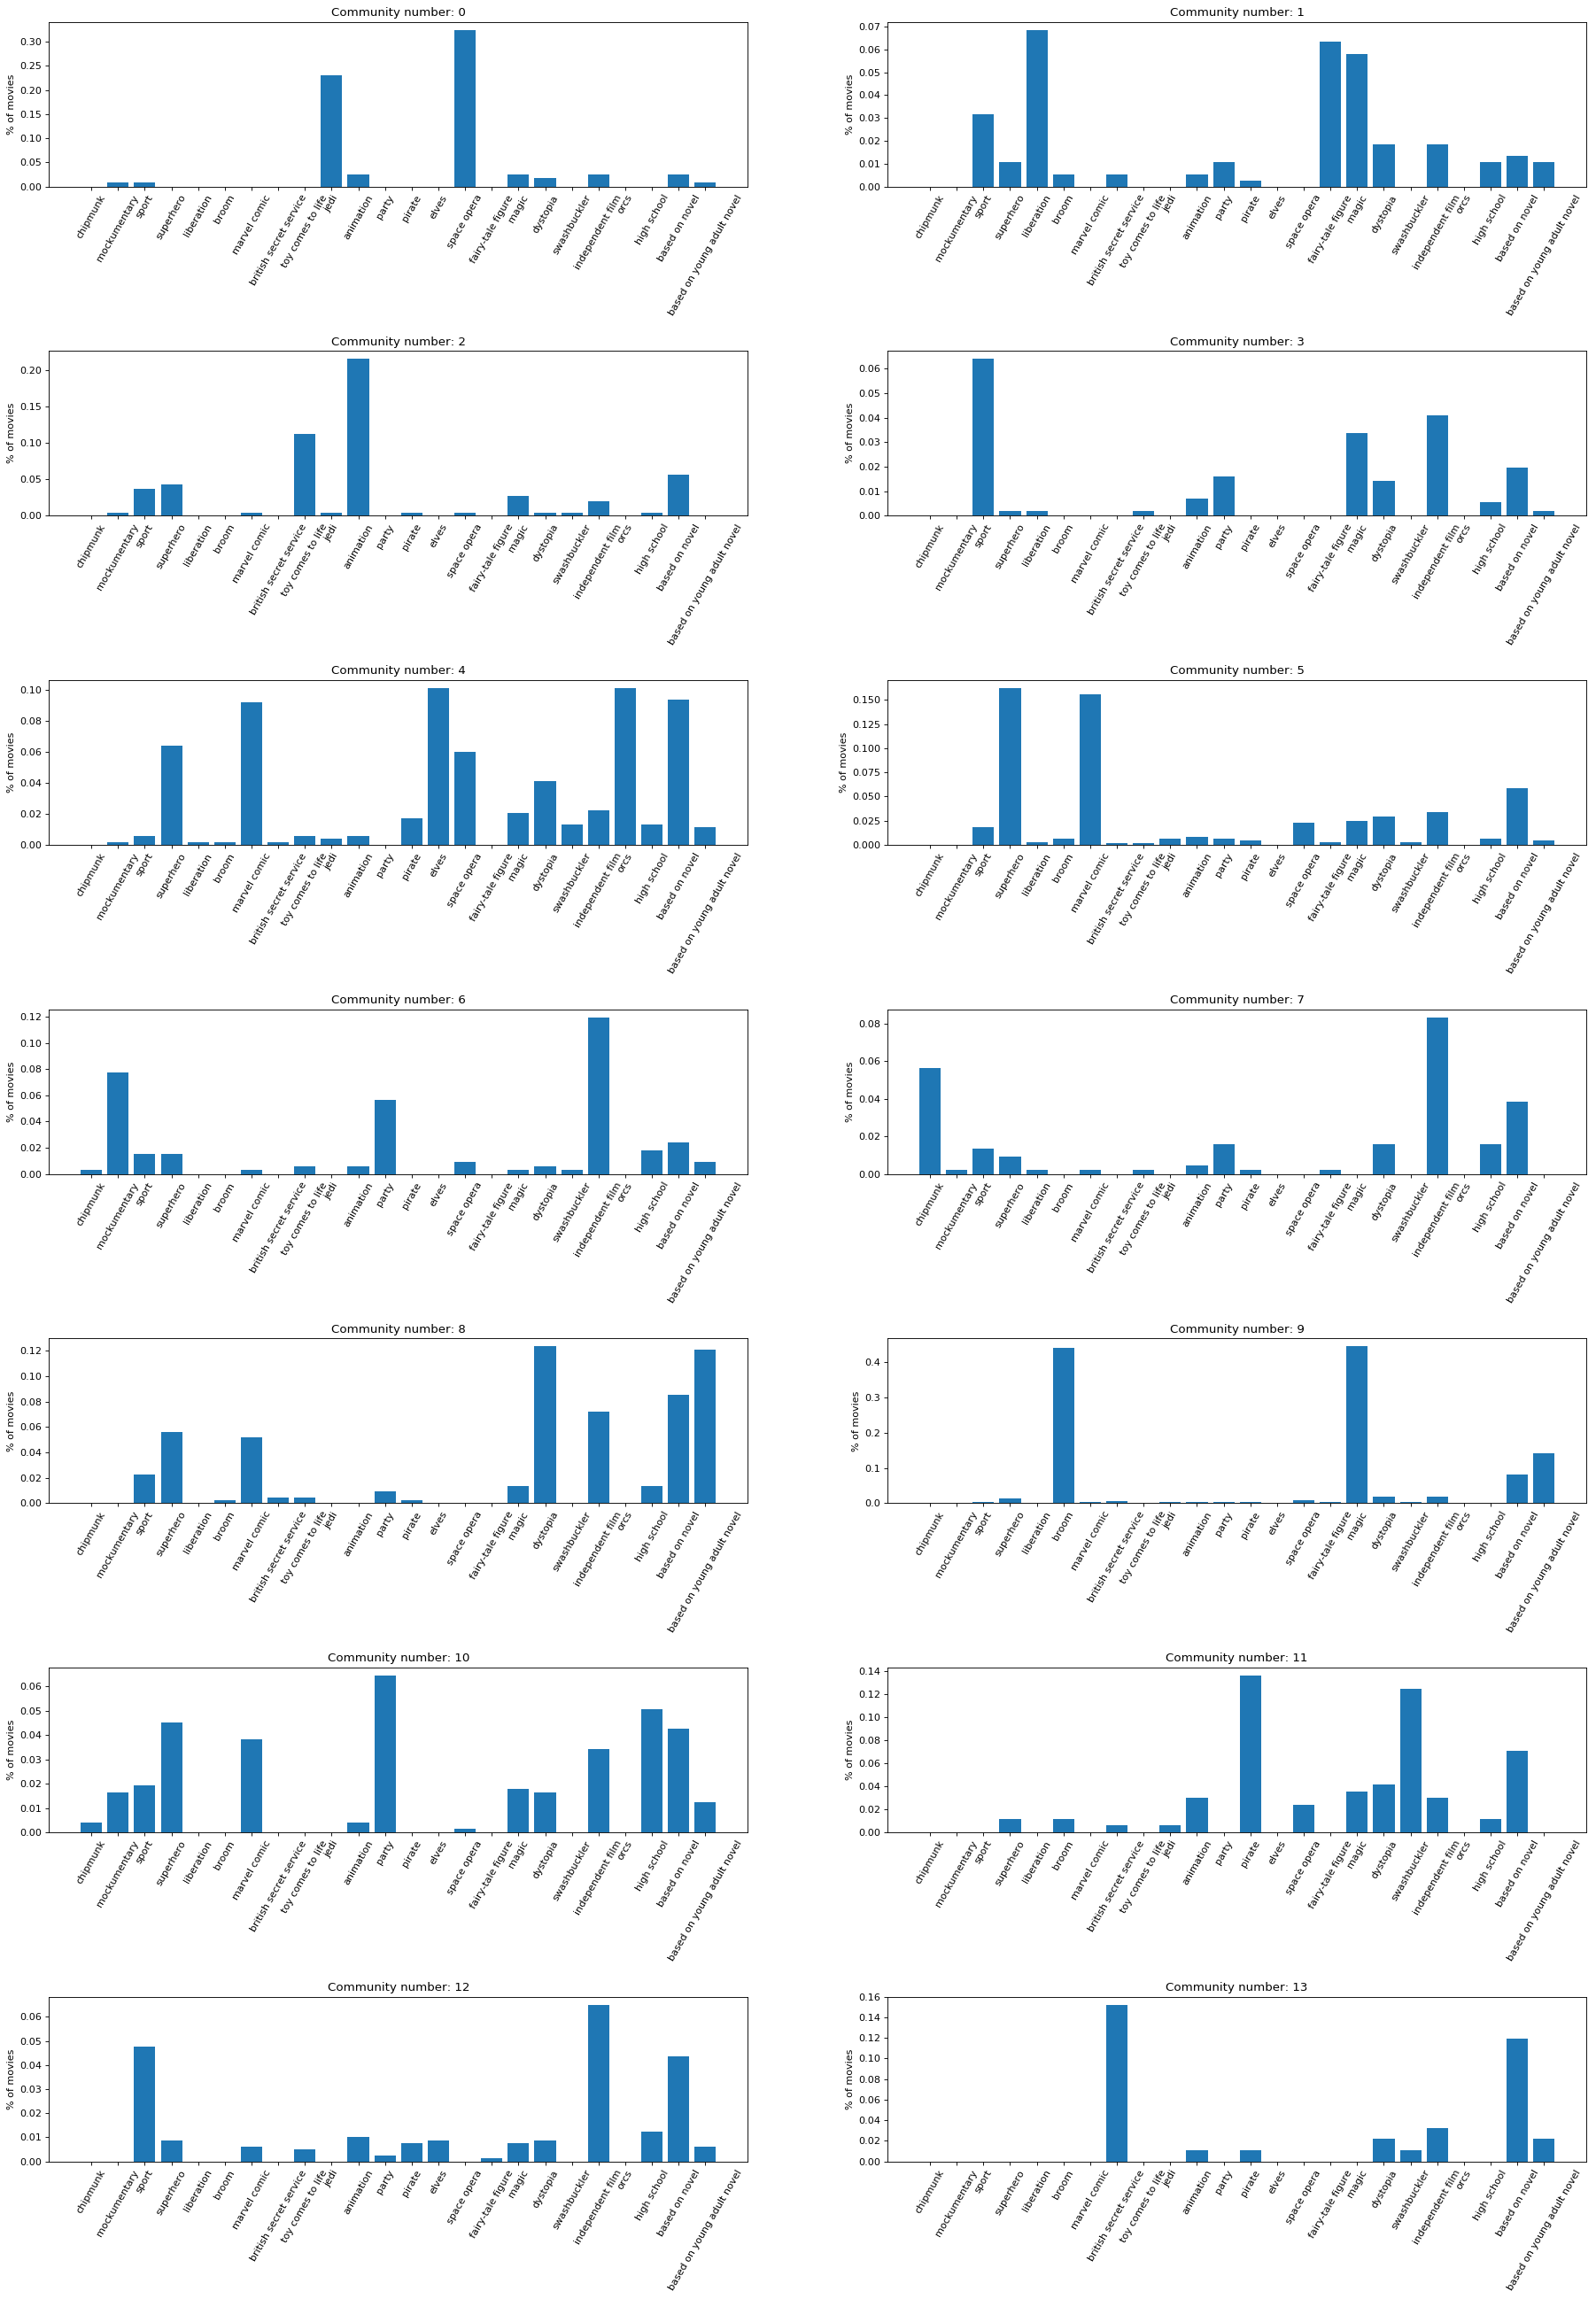

In [52]:
keyword_dict = {}
movie_count = {}
#As the following keywords shouldn't be a reason for seeing/not seeing a movie we will disregard them
not_interested = [u'duringcreditsstinger', u'aftercreditsstinger', u'woman director', u'sequel', u'3d']

#Loop through the partitions
for i in partition_cast:
    #We will create a dictionary for each partition
    if partition_cast[i] not in keyword_dict:
        keyword_dict[partition_cast[i]] = {}
    if partition_cast[i] not in movie_count:
        movie_count[partition_cast[i]] = 0
    for movie in cast[i]['movies']:
        movie_count[partition_cast[i]] += 1
        for keyword in tmdb_5000_movies[movie]['keywords']:
            #We count the number of genre occurences of the ones we are interested in
            if keyword['name'] not in not_interested:
                if keyword['name'] in keyword_dict[partition_cast[i]]:
                    keyword_dict[partition_cast[i]][keyword['name']] += 1
                else:
                    keyword_dict[partition_cast[i]][keyword['name']] = 1

#We don't want to look at all genres, let's just take the union of the 5 most common genres
names = []
for keyword in keyword_dict:
    keyword_counter = Counter(keyword_dict[keyword])
    names += [str(x[0]) for x in keyword_counter.most_common(2)]

#Plot our findings
names = set(names)
for keyword in keyword_dict:
    keyword_counter = Counter(keyword_dict[keyword])
    values = [keyword_counter[x]/movie_count[keyword] for x in names]
    plt.figure(num=14, figsize=(28, 40), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(7,2,keyword+1)
    plt.bar(range(0,len(names)), values)
    plt.xticks(range(0,len(names)), names, rotation=60)
    plt.title('Community number: ' + str(keyword))
    plt.ylabel('% of movies')

plt.subplots_adjust(hspace=1)
plt.show()

Here we start to see some interesting things for some communities. For example Community 0 has a dominance of 'space opera' and 'jedi' which tells us that the Star Wars films are in that community. Community 9 has many movies that have the keywords 'magic' and 'broom' which tells us that the Harry Potter movies are in that community amongst other movies about magic. Community 11 contains the Pirates of the Caribbean movies and that can also be seen in the barplot as 'pirate' and 'swashbuckler' is high.

### Betweenness centrality

In [7]:
#Calculate the betweenness of the network
betweenness = nx.betweenness_centrality(G_cast)

In [8]:
betweenness_sorted = sorted(betweenness.items(), key=operator.itemgetter(1), reverse=True)

# print out the list of the 5 pages that have the highest centrality :)

print ("{movie_s: <44} {centrality_d: <14}".format(
            movie_s = "Movie:", centrality_d = "Betweenness centrality value:"
        ))

print("--------------------------------------------------------------------------")

for page, centrality in betweenness_sorted[:5]:
    print ("{movie_s: <44} {centrality_d: <14}".format(
            movie_s = cast[page]['name'], centrality_d = round_sig(centrality,5)
        ))

Movie:                                       Betweenness centrality value:
--------------------------------------------------------------------------
Ben Stiller                                  0.10685       
Seth Rogen                                   0.10345       
Samuel L. Jackson                            0.10072       
John Ratzenberger                            0.090111      
J.K. Simmons                                 0.089986      


Note: As the movies are around 200 we'll not display them as to not make this notebook longer. Ben Stiller, Seth Rogen, Samuel L. Jackson and J.K. Simmons frequently act in movies where they're perhaps not the main actor but always a pretty big role. They also frequently act in movies that have more than one big name in the cast. For this reason it is understandable that they are hubs. John Ratzenberger is not a name we knew beforehand but he has voiced characters in some of the biggest animated movies for the last two decades, for example the Toy Story movies, the Cars movies, Incredibles and Up. He is clearly a hub for the animated movies in our dataset.

### Clustering coefficients

In [62]:
print "The clustering coefficent for the network is: {}".format(nx.average_clustering(G_cast))

The clustering coefficent for the network is: 0.388036744955


In [63]:
print "The clustering coefficent for the GCC of the network is: {}".format(nx.average_clustering(giant_cast))

The clustering coefficent for the GCC of the network is: 0.453924653501


### Conclusion
We see that this network is again not sufficient for our recommendation engine, at least not on its own. The clustering coefficient is fine and the modularity of our 18 communities is high but this network is focused on actors/actresses and not the movies themselves. Though people might like certain actors/actresses we don't want that to be the deciding factor alone when we recommend movies. We'll therefore move onto the next one and see if that has some interesting things to offer.

## Networks Conclusion
None of these networks will suffice by themselves for our recommendation engine. We will therefor make a network that is a mix of many different properties. That network will be crafted in a notebook of it's own as the code is quite long.